<a href="https://colab.research.google.com/github/shaida-abachi/shaida-abachi.github.io/blob/main/RM_algonauts_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Installations
%%capture
!pip install nilearn #Neuroimaging statistical analysis
!pip install decord #video processing
!pip install torchinfo
!pip install scikit-image

In [ ]:
#@title Imports
from itertools import combinations
import functools
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
from scipy.stats import zscore
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
from matplotlib import pyplot as plt
import nibabel as nib
import pickle
from nilearn import plotting
from tqdm import tqdm
from torchvision import transforms as trn
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from nilearn import datasets
from nilearn import surface
from decord import VideoReader
from decord import cpu
import pandas as pd
from torchinfo import summary
fsaverage = datasets.fetch_surf_fsaverage()
import pdb
import scipy

In [ ]:
data_root_path = '/content/drive/MyDrive/Algonauts_project'

In [ ]:
# @title helper functions - can hide
def save_dict(di_, filename_):  
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
        #print(p)
        #ret_di = pickle.load(f)
    return ret_di

def visualize_activity(vid_id,sub):
  # Setting up the paths for whole brain data
  fmri_dir = data_root_path + '/participants_data_v2021' 
  track = "full_track"

  # get the right track directory depending on whole brain/ROI choice
  track_dir = os.path.join(fmri_dir, track)  

  # get the selected subject's directory 
  sub_fmri_dir = os.path.join(track_dir, sub)
  
  #result directory to store nifti file
  #results_dir = '/content/'
  results_dir = data_root_path

  # mapping the data to voxels and storing in a nifti file
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:] 
  brain_mask = './example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)

  # visualizing saved nifti file
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

def get_subject_data(subject, ROI, video_indices = None):
  """
  This function given a subject number and ROI outputs the fMRI data.
  """
  fmri_dir = data_root_path + '/participants_data_v2021' 
  if ROI == "WB":  # Loading whole brain data 
    track = "full_track"  # stored in full_track directory
  else:  # Loading ROI data
    track = "mini_track" # stored in mini_track directory
    # get the right track directory depending on whole brain/ROI choice
  track_dir = os.path.join(fmri_dir, track)  

  # get the selected subject's directory 
  sub_fmri_dir = os.path.join(track_dir, subject)
  if track == "full_track":
    fmri_train_all, voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
    fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  if video_indices is not None:
    fmri_train_all = fmri_train_all[video_indices]
  return fmri_train_all

In [ ]:
# @title Computing the voxels size across subjects and the regions of interest
subjects = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]                       

df = pd.DataFrame(columns=['Subject']+ROIs)
for subject in subjects:
  row = [subject]
  for ROI in ROIs:
    fmri_data = get_subject_data(subject, ROI)
    row.append(fmri_data.shape[1])
  df.loc[len(df),:] = row

df 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-128-632946f18eaa>", line 9, in <module>
    fmri_data = get_subject_data(subject, ROI)
  File "<ipython-input-127-89470ee7b194>", line 91, in get_subject_data
    fmri_train_all, voxel_mask = get_fmri(sub_fmri_dir,ROI)
  File "<ipython-input-127-89470ee7b194>", line 61, in get_fmri
    ROI_data = load_dict(ROI_file)
  File "<ipython-input-127-89470ee7b194>", line 10, in load_dict
    ret_di = u.load()
  File "/usr/lib/python3.7/pickle.py", line 1088, in load
    dispatch[key[0]](self)
  File "/usr/lib/python3.7/pickle.py", line 1230, in load_binbytes
    self.append(self.read(len))
  File "/usr/lib/python3.7/pickle.py", line 265, in read
    return self.file_read(n)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most rece

KeyboardInterrupt: ignored

In [ ]:
#@title Loading fMRI data and inspecting dimensions
# # Select Subject
# sub = 'sub07'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
# # Select ROI
# ROI = 'V1'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
# ######## fMRI data loader wrapper code ###################################
# fmri_dir = data_root_path + '/participants_data_v2021' 
# if ROI == "WB":  # Loading whole brain data 
#     track = "full_track"  # stored in full_track directory
# else:  # Loading ROI data
#     track = "mini_track" # stored in mini_track directory

# # get the right track directory depending on whole brain/ROI choice
# track_dir = os.path.join(fmri_dir, track)  

# # get the selected subject's directory 
# sub_fmri_dir = os.path.join(track_dir, sub)

# # Load the fMRI data for the selected subject and ROI
# if track == "full_track":
#     fmri_train_all, voxel_mask = get_fmri(sub_fmri_dir,ROI)
# else:
#     fmri_train_all = get_fmri(sub_fmri_dir,ROI)

# ######## fMRI data loader wrapper code ###################################

# # Visualize the fMRI responses in a heatmap
# f, ax = plt.subplots(figsize=(12, 5))
# ax.set(xlabel="Voxel", ylabel="Stimulus")
# heatmap = ax.imshow(fmri_train_all, aspect="auto",cmap='jet',vmin=-1,vmax=1)
# f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
# f.tight_layout()

In [ ]:
#@title AlexNet
__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        #maybe replace this by a hook so we can
        #train
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

In [ ]:
#@title Utility functions for regression
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X =  self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry =  self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
    """This function fits a linear regressor using train_activations and train_fmri,
    then returns the predicted fmri_pred_test using the fitted weights and
    test_activations.
    Parameters
    ----------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos.
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    train_fmri : np.array
        matrix of dimensions #train_vids x  #voxels
        containing fMRI responses to train videos
    use_gpu : bool
        Description of parameter `use_gpu`.
    Returns
    -------
    fmri_pred_test: np.array
        matrix of dimensions #test_vids x  #voxels
        containing predicted fMRI responses to test videos .
    """

    reg = OLS_pytorch(use_gpu)
    reg.fit(train_activations,train_fmri.T)
    fmri_pred_test = reg.predict(test_activations)
    return fmri_pred_test


In [ ]:
#@title Utility functions for data loading
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def visualize_activity(vid_id,sub):
  fmri_dir = './participants_data_v2021' 
  track = "full_track"
  results_dir = '/content/'
  track_dir = os.path.join(fmri_dir, track) 
  sub_fmri_dir = os.path.join(track_dir, sub)
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB") 
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = '/content/example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)

def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    test_activations = np.load(test_file)
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.fit_transform(test_activations)

    return train_activations, test_activations

def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """


    # Loading ROI data
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
    img = nib.load(brain_mask)
    nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
    nib.save(nii_img, nii_save_path)

In [ ]:
# @title PERFORM ENCODING FUNCTION
def perform_encoding(activation_dir, fmri_dir,results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
  if torch.cuda.is_available():
      use_gpu = True
  else:
      use_gpu = False

  ###### Load activations ##############
  activations_dir = data_root_path + '/activations_alexnet'
  pca_dir = os.path.join(activations_dir,'pca_100')
  train_activations,test_activations = get_activations(pca_dir, layer)
  ######################################

  ##### Load fMRI data #################
  if ROI == "WB":
      track = "full_track"
  else:
      track = "mini_track"
  fmri_dir = os.path.join(fmri_dir, track)
  sub_fmri_dir = os.path.join(fmri_dir, sub)
  if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
  else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
  num_voxels = fmri_train_all.shape[1]
  ######################################


  #### Creating data splits ###############
  if mode == 'val':
      # Here as an example we use first 900 videos as training and rest of the videos as validation
      test_activations = train_activations[900:,:]
      train_activations = train_activations[:900,:]
      fmri_train = fmri_train_all[:900,:]
      fmri_test = fmri_train_all[900:,:]
      pred_fmri = np.zeros_like(fmri_test)
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
  else:
      fmri_train = fmri_train_all
      num_test_videos = 102
      pred_fmri = np.zeros((num_test_videos,num_voxels))
      pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
  ######################################

  ######## Performing regression ################
  iter = 0
  
  while iter < num_voxels-batch_size:
      pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
      iter = iter+batch_size
  pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
  if mode == 'val':
    score = vectorized_correlation(fmri_test,pred_fmri)
    #print("----------------------------------------------------------------------------")
    #print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
    ################################################
    
    nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
    ######## Result visualization ################
    if track == "full_track" and visualize_results:
        visual_mask_3D = np.zeros((78,93,71))
        visual_mask_3D[voxel_mask==1]= score
        brain_mask = '/content/example.nii'
        saveasnii(brain_mask,nii_save_path,visual_mask_3D)
        plotting.plot_glass_brain(nii_save_path,plot_abs=False,
                          title='Correlation for ' + sub+ ' and ' + layer,
                          display_mode='lyr',colorbar=True,vmin=-1,vmax=1)

    ################################################
  #pdb.set_trace()
  #print(score.shape)
  np.save(pred_fmri_save_path, pred_fmri)
  #return round(score.mean(), 6)
  return score

In [ ]:
#@title Perform and evaluate encoding on validation set
# sub = 'sub04'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

# ROI = 'LOC'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

# layer = 'layer_2' #@param ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]

# activations_dir = data_root_path + '/activations_alexnet'

# fmri_dir = data_root_path + '/participants_data_v2021'
# prediction_dir = data_root_path + '/prediction'
# model = 'alexnet'

# if ROI == "WB":
#     track = "full_track"
# else:
#     track = "mini_track"

# results_dir = os.path.join(prediction_dir,model, layer,\
#                            track, sub)
# if not os.path.exists(results_dir):
#   os.makedirs(results_dir)
# perform_encoding(activations_dir, fmri_dir,\
#                                  results_dir, sub, layer, ROI=ROI)
  

In [ ]:
#@title Perform and evaluate encoding on validation set, and save data into file

# set these vars: 
##########
project_path = '/content/drive/MyDrive/Algonauts_project'
results_save_dir = '/AlexNet_original' # e.g. AlexNet_original OR AlexNet_HueModifications etc...
activations_dir = '/activations_alexnet' 
data_dir = '/participants_data_v2021'
pred_dir = '/prediction'
##########

sub = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  

ROI = ["V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

layer = ["layer_1","layer_2","layer_3","layer_4","layer_5","layer_6","layer_7","layer_8"]

subject_list=[]
data_list = []
layer_list = []
roi_list = []

for subjects in sub:
    #roi_list=[]
    for ROIs in ROI:
        for layers in layer:
            #print(subjects + ' ' ROIs + layers)
            txt = [subjects, ROIs, layers]
            #print(' '.join(txt))
            outdata = perform_encoding(project_path + activations_dir, project_path + data_dir, project_path + pred_dir, subjects, layers, ROI = ROIs)
            subject_list.append(subjects)
            layer_list.append(layers)
            roi_list.append(ROIs)
            data_list.append(outdata)

results_save_fullpath = project_path + results_save_dir
if not(os.path.isdir(results_save_fullpath)):
  os.mkdir(results_save_fullpath)
print('will save files to ' + results_save_fullpath)

np.save(os.path.join(results_save_fullpath, 'data_list.npy') , data_list, allow_pickle=True)
np.save(os.path.join(results_save_fullpath, 'subject_list.npy') , subject_list)
np.save(os.path.join(results_save_fullpath, 'layer_list.npy') , layer_list)
np.save(os.path.join(results_save_fullpath, 'roi_list.npy') , roi_list)

print('finished save')



In [ ]:
# IMPORT DATA HERE
whichmodel = 'vgg16'
#whichmodel = 'AlexNet'
#whichmodel = 'resnet50'
#whichmodel = 'slowfast'
#which_color_manip = 'grayscale'
#which_color_manip = 'chroma150'
which_color_manip = 'hue180'

# ORIGINAL DATA 
#results_save_fullpath = data_root_path + '/vgg16'
#results_save_fullpath = data_root_path + '/AlexNet_original'
results_save_fullpath = data_root_path + '/' + whichmodel + '_original'
data_list0 = np.load(os.path.join(results_save_fullpath, 'data_list.npy'), allow_pickle=True)
subject_list0 = np.load(os.path.join(results_save_fullpath, 'subject_list.npy'))
roi_list0 = np.load(os.path.join(results_save_fullpath, 'roi_list.npy'))
layer_list0 = np.load(os.path.join(results_save_fullpath, 'layer_list.npy'))

# COLOR MANIPULATED DATA 
#results_save_fullpath = data_root_path + '/vgg16_grey'
#results_save_fullpath = data_root_path + '/AlexNet_grayscale'
results_save_fullpath = data_root_path + '/' + whichmodel + '_' + which_color_manip
data_list1 = np.load(os.path.join(results_save_fullpath, 'data_list.npy'), allow_pickle=True)
subject_list1 = np.load(os.path.join(results_save_fullpath, 'subject_list.npy'))
roi_list1 = np.load(os.path.join(results_save_fullpath, 'roi_list.npy'))
layer_list1 = np.load(os.path.join(results_save_fullpath, 'layer_list.npy'))

In [ ]:
# @title Helper functions for plotting code below
def rm_box(ax): 
  right_side = ax.spines["right"]
  top = ax.spines["top"]
  right_side.set_visible(False)
  top.set_visible(False)

def make_model(data_list, layer_list, subject_list, roi_list): 
  model_out = []
  model_out.append(data_list)
  model_out.append(layer_list)
  model_out.append(subject_list)
  model_out.append(roi_list)
  # if len(args)>0: 
  #   pdb.set_trace()
  #   model_out.modelname = args[1]
  #   model_out.manip = args[2]
  return model_out

def unpack_model(model_in): 
  data_list = np.array(model_in[0])
  layer_list = np.array(model_in[1])
  subj_list = np.array(model_in[2])
  roi_list = np.array(model_in[3])
  return data_list, layer_list, subj_list, roi_list

In [ ]:
#@title Plots by subject - can hide 
# roi_filt = ['V1', 'V2', 'V3', 'V4', 'EBA', 'FFA', 'LOC', 'PPA', 'STS']
# layer_filt = ['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8']
# these_idx = []
# jitteramt = 0.5; 
# nrows = len(roi_filt)
# ncols = len(layer_filt)
# ax = []

# plot_scatters_flag = False

# #plt.figure(figsize = [5,10], dpi = 100)
# #f, axs = plt.subplot(nrows, nrcols)
# fig, axs = plt.subplots(nrows, ncols, sharey=True)

# for pi_y, _ in enumerate(roi_filt):
#   for pi_x, _ in enumerate(layer_filt):
  
#     #plt.subplot(nrows, ncols, plotidx+1)

#     ctr = 0 
#     for idx1, roi_curr in enumerate(roi_list):
#       layer_curr = layer_list[idx1]
#       subj_curr = subject_list[idx1]
#       if roi_curr == roi_filt[pi_y] and layer_curr == layer_filt[pi_x]:
#         #print(data_list[idx1])
#         these_idx.append(idx1)
#         data_curr = np.array(data_list[idx1])
#         ctr = ctr+1; 
#         if plot_scatters_flag: 
#           jitter = np.random.rand(1, data_curr.size)*jitteramt - jitteramt/2
#           yvals = np.ones([1,len(data_list[idx1])])*ctr
#           axs[pi_y, pi_x].scatter(yvals+jitter, data_list[idx1], alpha = 0.05, s=8)     

#         # overlay errorbars with median +/- std 
#         med = np.median(data_curr)
#         std = np.std(data_curr)
#         axs[pi_y, pi_x].errorbar(ctr, med, std, fmt='o', label=subj_curr)


#         #plt.show()
#         #print(quartile1, medians, quartile3)
#     axs[pi_y, pi_x].grid()
#     axs[pi_y, pi_x].set_title(f'{roi_filt[pi_y]}, {layer_filt[pi_x]}')
#     axs[pi_y, pi_x].set_ylabel('correlation value')
#     #if pi_y == len(roi_filt)-1:
#     #  axs[pi_x, pi_y].set_xlabel('subject')
#     axs[pi_y, pi_x].set_xticks([])   
#     rm_box(axs[pi_y, pi_x])

# fig.set_size_inches(18,20)
# fig.set_dpi = 100 

# fig.legend(['sub01', 'sub02', 'sub03',\
#             'sub04', 'sub05', 'sub06',\
#             'sub07', 'sub07', 'sub08',\
#             'sub09', 'sub10'])



In [ ]:
# STATS FOR COMPARING OUTPUTS OF MODELS 

m0 = make_model(data_list0, layer_list0, subject_list0, roi_list0)
m1 = make_model(data_list1, layer_list1, subject_list1, roi_list1)

def compare_model_outputs(model0, model1):
  # use wilcoxon signed-rank test to compare model corrs at different layer-ROI combos
  # NEED: bonferroni correct for number of comparisons (or a friendlier method...)

  for i in range(len(model0)): 
    assert(len(model0[i]) == len(model1[i])), "error: incompatible sizes" 

  data_list0, layer_list0, subj_list0, roi_list0 = unpack_model(model0)
  #data_list0 = np.array(model0[0])
  #layer_list0 = np.array(model0[1])
  #subj_list0 = np.array(model0[2])
  #roi_list0 = np.array(model0[3])
  data_list1, layer_list1, subj_list1, roi_list1 = unpack_model(model1)
  # data_list1 = np.array(model1[0])
  # layer_list1 = np.array(model1[1])
  # subj_list1 = np.array(model1[2])
  # roi_list1 = np.array(model1[3])

  layers_un = np.unique(layer_list0)
  rois_sort = ['V1', 'V2', 'V3',\
               'V4', 'EBA', 'FFA',\
               'STS', 'LOC', 'PPA'] #order from low -> mid -> hi

  df = pd.DataFrame()
  # pdb.set_trace()
  for xidx, layer in enumerate(layers_un):
    print(layer) 
    pvals = np.zeros(len(rois_sort))
    wvals = np.zeros(len(rois_sort))
    for yidx, roi in enumerate(rois_sort): 
      curr_idx = np.intersect1d(np.argwhere(roi_list0 == roi), np.argwhere(layer_list0 == layer))
      data_curr0 = np.concatenate(data_list0[curr_idx])
      data_curr1 = np.concatenate(data_list1[curr_idx])
      #print(len(data_curr0), len(data_curr1))
      w, p = scipy.stats.wilcoxon(data_curr0, data_curr1+np.random.random(len(data_curr1))-0.5) # DUMMY
      #w, p = scipy.stats.wilcoxon(data_curr0, data_curr1)
      if np.isnan(p):
        pdb.set_trace()
      pvals[yidx] = p
      wvals[yidx] = p
    df_one = pd.DataFrame(pvals, index = rois_sort, columns = [layer])
    
    df = pd.concat([df, df_one], axis = 1)
  return df

df = compare_model_outputs(m0, m1)
df.style.set_caption("P values - Wilcoxon")
print("P values - Wilcoxon sign rank comparison of models")
df
# df_adj

block_5
block_6_proj
fast_pathway_1
fast_pathway_2
fast_pathway_3
fast_pathway_4
slow_pathway_3
slow_pathway_4
P values - Wilcoxon sign rank comparison of models


,block_5,block_6_proj,fast_pathway_1,fast_pathway_2,fast_pathway_3,fast_pathway_4,slow_pathway_3,slow_pathway_4
V1,0.293774,0.389044,0.517830,0.413863,0.735504,0.906111,0.481890,0.941692
V2,0.439334,0.685748,0.809946,0.427823,0.996168,0.637646,0.844821,0.993131
V3,0.033797,0.862210,0.471817,0.244586,0.956781,0.524674,0.020083,0.063361
V4,0.780152,0.776350,0.570921,0.854991,0.078479,0.220292,0.748829,0.634130
EBA,0.065766,0.774056,0.261015,0.005796,0.070261,0.937311,0.927057,0.934834
FFA,0.954599,0.428958,0.767847,0.012624,0.347244,0.565025,0.004103,0.324335
STS,0.188686,0.811126,0.272268,0.464530,0.248488,0.263737,0.867828,0.080470
LOC,0.945617,0.648657,0.524046,0.000560,0.014474,0.001217,0.002212,0.000065
PPA,0.020357,0.370766,0.308432,0.561319,0.694977,0.967204,0.000048,0.269063


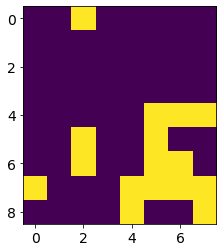

In [ ]:
alpha = 0.001
plt.imshow(df<alpha)

vgg16


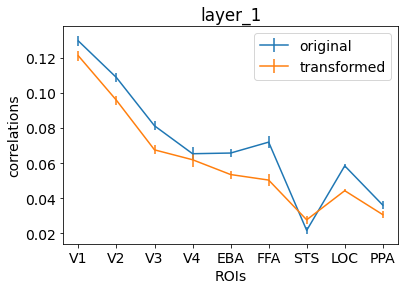

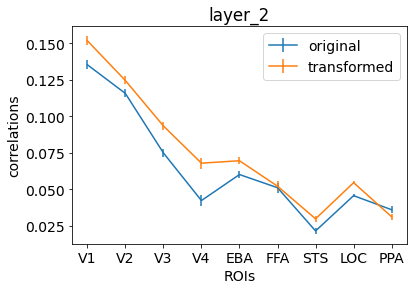

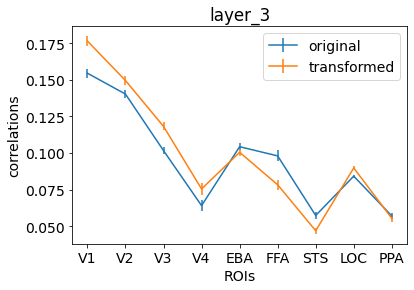

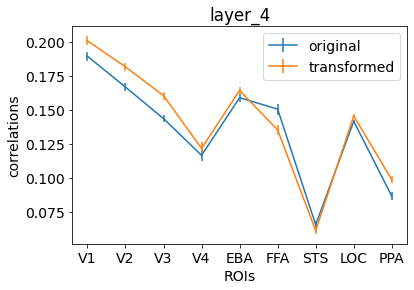

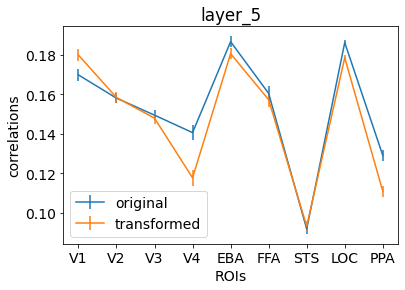

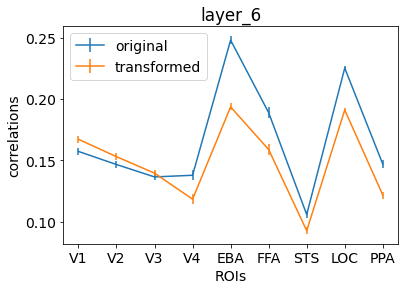

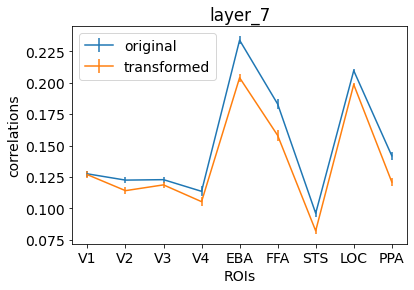

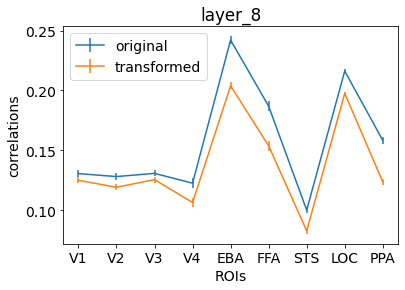

In [ ]:
# FIGURES FOR COMPARING OUTPUTS OF MODELS - BY LAYER 
def model_output_comparison_plot(model0, model1, whichlayer):
  # use wilcoxon signed-rank test to compare model corrs at different layer-ROI combos

  for i in range(len(model0)): 
    assert(len(model0[i]) == len(model1[i])), "error: incompatible sizes" 

  data_list0, layer_list0, subj_list0, roi_list0 = unpack_model(model0)
  data_list1, layer_list1, subj_list1, roi_list1 = unpack_model(model1)

  layers_un = np.unique(layer_list0)
  rois_sort = ['V1', 'V2', 'V3',\
               'V4', 'EBA', 'FFA',\
               'STS', 'LOC', 'PPA'] #order from low -> mid -> hi

  plt.figure()
  plt.title(whichlayer)
  plt.xlabel("ROIs")
  plt.ylabel("correlations")
  layer = whichlayer

  med0 = np.zeros(len(rois_sort))
  med1 = np.zeros(len(rois_sort))
  sem0 = np.zeros(len(rois_sort))
  sem1 = np.zeros(len(rois_sort))
  for idx, roi in enumerate(rois_sort): 
      curr_idx = np.intersect1d(np.argwhere(roi_list0 == roi), np.argwhere(layer_list0 == layer))
      data_curr0 = np.concatenate(data_list0[curr_idx])
      data_curr1 = np.concatenate(data_list1[curr_idx])
      med0[idx] = np.median(data_curr0)
      med1[idx] = np.median(data_curr1)
      sem0[idx] = np.std(data_curr0)/np.sqrt(len(data_curr0))
      sem1[idx] = np.std(data_curr1)/np.sqrt(len(data_curr1))
      #print(roi)
  xvals = np.arange(len(rois_sort))
  plt.errorbar(xvals, med0, sem0, label = 'original')
  plt.errorbar(xvals, med1, sem1, label = 'transformed')
  plt.legend()
  plt.xticks(xvals, rois_sort)

layers_un = np.unique(layer_list0)
print(whichmodel)
for layer in layers_un:
  model_output_comparison_plot(m0, m1, layer)


vgg16
original vs. hue180


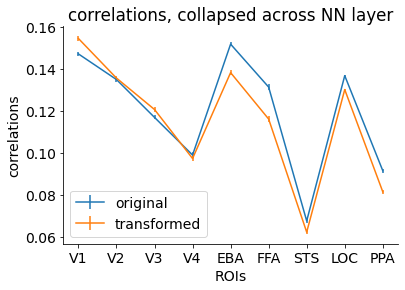

In [ ]:
# FIGURE FOR COMPARING OUTPUTS OF MODELS: COLLAPSED ACROSS LAYER 
def model_output_comparison_plot(model0, model1):

  data_list0, layer_list0, subj_list0, roi_list0 = unpack_model(model0)
  data_list1, layer_list1, subj_list1, roi_list1 = unpack_model(model1)

  layers_un = np.unique(layer_list0)
  rois_sort = ['V1', 'V2', 'V3',\
               'V4', 'EBA', 'FFA',\
               'STS', 'LOC', 'PPA'] #order from low -> mid -> hi

  plt.figure()
  plt.xlabel("ROIs")
  plt.ylabel("correlations")

  layers_un = np.unique(layer_list0)

  med0 = np.zeros(len(rois_sort))
  med1 = np.zeros(len(rois_sort))
  sem0 = np.zeros(len(rois_sort))
  sem1 = np.zeros(len(rois_sort))
  for idx, roi in enumerate(rois_sort):  
    curr_idx = np.argwhere(roi_list0 == roi)
    curr_idx = np.squeeze(curr_idx)
    data_curr0 = np.concatenate(data_list0[curr_idx])
    data_curr1 = np.concatenate(data_list1[curr_idx])

    med0[idx] = np.median(data_curr0)
    med1[idx] = np.median(data_curr1)
    sem0[idx] = np.std(data_curr0)/np.sqrt(len(data_curr0))
    sem1[idx] = np.std(data_curr1)/np.sqrt(len(data_curr1))

  xvals = np.arange(len(rois_sort))
  plt.errorbar(xvals, med0, sem0, label = 'original')
  plt.errorbar(xvals, med1, sem1, label = 'transformed')
  plt.legend()
  plt.xticks(xvals, rois_sort)
  ax = plt.gca()
  plt.title("correlations, collapsed across NN layer")
  rm_box(ax)
  plt.rcParams.update({'font.size': 14})

  return ax

print(whichmodel)
print("original vs. " + which_color_manip)
model_output_comparison_plot(m0, m1)


In [ ]:
# FIGURE FOR COMPARING OUTPUTS OF MODELS: COLLAPSED ACROSS LAYER 

# m0 = make_model(data_list0, layer_list0, subject_list0, roi_list0)

# def model_output_comparison_plot(model0):

#   data_list0, layer_list0, subj_list0, roi_list0 = unpack_model(model0)

#   layers_un = np.unique(layer_list0)
#   rois_sort = ['V1', 'V2', 'V3',\
#                'V4', 'EBA', 'FFA',\
#                'STS', 'LOC', 'PPA'] #order from low -> mid -> hi

#   plt.figure()
#   plt.xlabel("ROIs")
#   plt.ylabel("correlations")

#   layers_un = np.unique(layer_list0)

#   med0 = np.zeros(len(rois_sort))
#   med1 = np.zeros(len(rois_sort))
#   sem0 = np.zeros(len(rois_sort))
#   sem1 = np.zeros(len(rois_sort))
#   for idx, roi in enumerate(rois_sort):  
#     curr_idx = np.argwhere(roi_list0 == roi)
#     curr_idx = np.squeeze(curr_idx)
#     data_curr0 = np.concatenate(data_list0[curr_idx])
#     #data_curr1 = np.concatenate(data_list1[curr_idx])

#     med0[idx] = np.median(data_curr0)
#     #med1[idx] = np.median(data_curr1)
#     sem0[idx] = np.std(data_curr0)/np.sqrt(len(data_curr0))
#    # sem1[idx] = np.std(data_curr1)/np.sqrt(len(data_curr1))

#   xvals = np.arange(len(rois_sort))
#   plt.errorbar(xvals, med0, sem0, label = 'original')
#   #plt.errorbar(xvals, med1, sem1, label = 'transformed')
#   plt.legend()
#   plt.xticks(xvals, rois_sort)
#   ax1 = plt.gca()
#   plt.title("correlations, collapsed across NN layer")
#   rm_box(ax1)

# print(whichmodel)
# print("original")
# model_output_comparison_plot(m0)

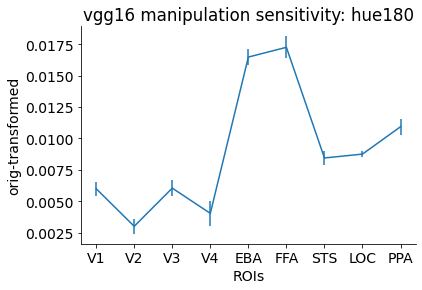

In [ ]:
# FIGURE FOR COMPARING OUTPUTS OF MODELS: COLLAPSED ACROSS LAYER 
def manipulation_sensitivity_plot(model0, model1):
  
  data_list0, layer_list0, subj_list0, roi_list0 = unpack_model(model0)
  data_list1, layer_list1, subj_list1, roi_list1 = unpack_model(model1)

  layers_un = np.unique(layer_list0)
  rois_sort = ['V1', 'V2', 'V3',\
               'V4', 'EBA', 'FFA',\
               'STS', 'LOC', 'PPA'] #order from low -> mid -> hi

  plt.figure()
  layers_un = np.unique(layer_list0)

  diff_vect = np.zeros(len(rois_sort))
  diff_std = np.zeros(len(rois_sort))
  diff_sem = np.zeros(len(rois_sort))
  for idx, roi in enumerate(rois_sort):  
    curr_idx = np.argwhere(roi_list0 == roi)
    curr_idx = np.squeeze(curr_idx)
    data_curr0 = np.concatenate(data_list0[curr_idx])
    data_curr1 = np.concatenate(data_list1[curr_idx])
    diff_vect[idx] = np.median(data_curr0-data_curr1)
    diff_std[idx] = np.std(data_curr0-data_curr1)
    diff_sem[idx] = abs(np.std(data_curr0-data_curr1))/np.sqrt(len(data_curr0))

  xvals = np.arange(len(rois_sort))
  #plt.plot(diff_vect)
  plt.errorbar(xvals, abs(diff_vect), diff_sem)
  plt.xticks(xvals, rois_sort)
  plt.title(whichmodel + " manipulation sensitivity: " + which_color_manip)
  ax = plt.gca()
  rm_box(ax)
  plt.xlabel("ROIs")
  plt.ylabel("orig-transformed")
  plt.rcParams.update({'font.size': 14})
    

manipulation_sensitivity_plot(m0, m1)


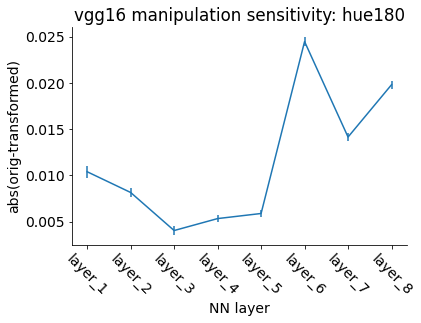

In [ ]:
# FIGURE FOR COMPARING OUTPUTS OF MODELS: COLLAPSED ACROSS LAYER 
def manipulation_sensitivity_plot_layers(model0, model1):
  
  data_list0, layer_list0, subj_list0, roi_list0 = unpack_model(model0)
  data_list1, layer_list1, subj_list1, roi_list1 = unpack_model(model1)

  layers_un = np.unique(layer_list0)
  rois_sort = ['V1', 'V2', 'V3',\
               'V4', 'EBA', 'FFA',\
               'STS', 'LOC', 'PPA'] #order from low -> mid -> hi

  plt.figure()
  layers_un = np.unique(layer_list0)

  diff_vect = np.zeros(len(layers_un))
  diff_std = np.zeros(len(layers_un))
  diff_sem = np.zeros(len(layers_un))
  for idx, layer in enumerate(layers_un):  
    #curr_idx = np.argwhere(roi_list0 == roi)
    curr_idx = np.argwhere(layer_list0 == layer)
    curr_idx = np.squeeze(curr_idx)
    data_curr0 = np.concatenate(data_list0[curr_idx])
    data_curr1 = np.concatenate(data_list1[curr_idx])
    diff_vect[idx] = np.median(data_curr0-data_curr1)
    diff_std[idx] = np.std(data_curr0-data_curr1)
    diff_sem[idx] = abs(np.std(data_curr0-data_curr1))/np.sqrt(len(data_curr0))
  #pdb.set_trace()
  xvals = np.arange(len(layers_un))
  #plt.plot(diff_vect)
  #plt.plot(diff_vect)
  #pdb.set_trace()
  ax = plt.gca()
  plt.errorbar(xvals, abs(diff_vect), diff_sem)
  ax.set_xticklabels(ax.get_xticks(), rotation = -45)
  plt.xticks(xvals, layers_un)
  plt.title(whichmodel + " manipulation sensitivity: " + which_color_manip)

  rm_box(ax)
  plt.xlabel("NN layer")
  plt.ylabel("abs(orig-transformed)")
  plt.rcParams.update({'font.size': 14})
  #
    

manipulation_sensitivity_plot_layers(m0, m1)

vgg16
hue180


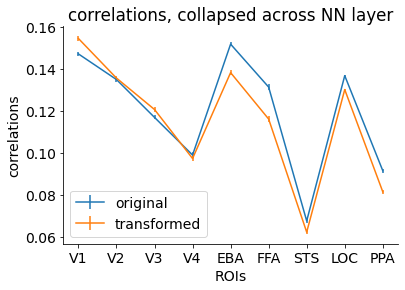

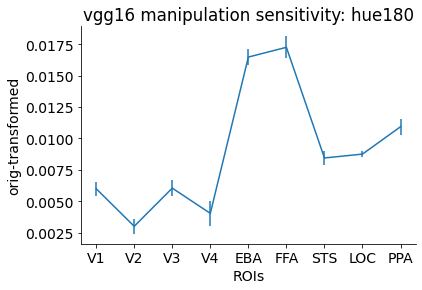

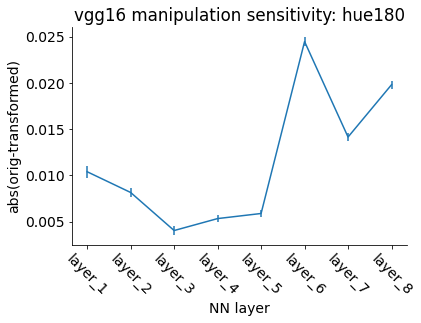

In [ ]:
# MAKE THREE PLOTS: 
# 1.orig vs manip by ROI, collapsed across NN layer 
# 2.abs difference of orig vs manip by ROI, collapsed across NN layer 
# 3.abs difference of orig vs manip by ROI, collapsed across region

print(whichmodel)
print(which_color_manip)

# 1.
model_output_comparison_plot(m0, m1)

# 2. 
manipulation_sensitivity_plot(m0, m1)

#3. 
manipulation_sensitivity_plot_layers(m0, m1)

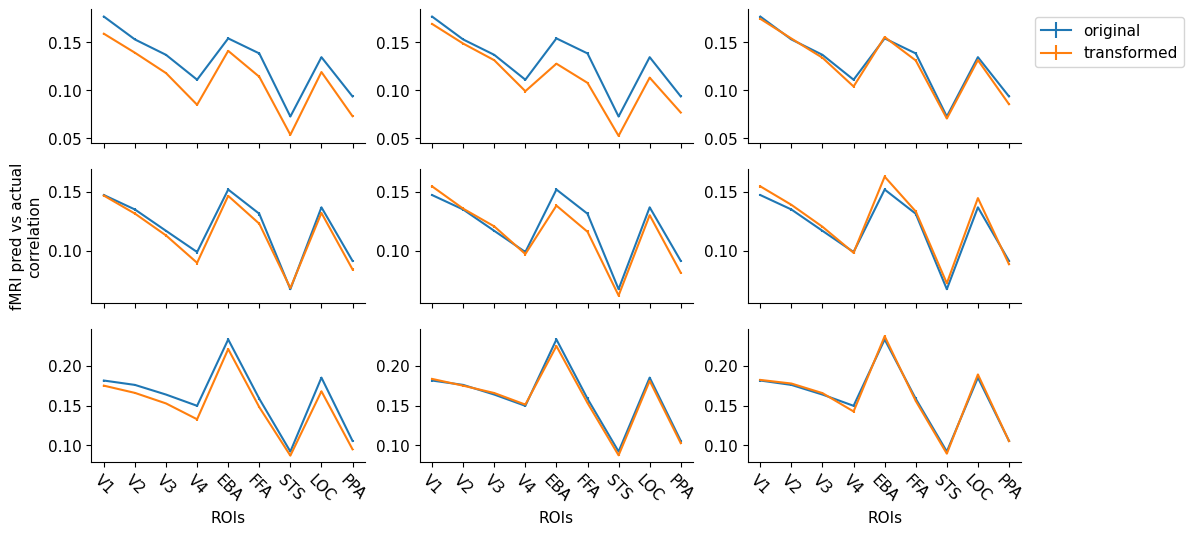

In [ ]:
# FIGURE FOR COMPARING OUTPUTS OF MODELS: COLLAPSED ACROSS LAYER 
def model_output_comparison_subplot(model0, model1):

  data_list0, layer_list0, subj_list0, roi_list0 = unpack_model(model0)
  data_list1, layer_list1, subj_list1, roi_list1 = unpack_model(model1)

  layers_un = np.unique(layer_list0)
  rois_sort = ['V1', 'V2', 'V3',\
               'V4', 'EBA', 'FFA',\
               'STS', 'LOC', 'PPA'] #order from low -> mid -> hi

  #plt.figure()
  plt.xlabel("ROIs")
  plt.ylabel("fMRI pred vs actual\ncorrelation")

  layers_un = np.unique(layer_list0)

  med0 = np.zeros(len(rois_sort))
  med1 = np.zeros(len(rois_sort))
  sem0 = np.zeros(len(rois_sort))
  sem1 = np.zeros(len(rois_sort))
  for idx, roi in enumerate(rois_sort):  
    curr_idx = np.argwhere(roi_list0 == roi)
    curr_idx = np.squeeze(curr_idx)
    data_curr0 = np.concatenate(data_list0[curr_idx])
    data_curr1 = np.concatenate(data_list1[curr_idx])

    med0[idx] = np.median(data_curr0)
    med1[idx] = np.median(data_curr1)
    sem0[idx] = np.std(data_curr0)/np.sqrt(len(data_curr0))
    sem1[idx] = np.std(data_curr1)/np.sqrt(len(data_curr1))

  xvals = np.arange(len(rois_sort))
  plt.errorbar(xvals, med0, sem0, label = 'original')
  plt.errorbar(xvals, med1, sem1, label = 'transformed')
  plt.legend(bbox_to_anchor=(1.02,1))
  plt.xticks(xvals, rois_sort, rotation=-45)
  ax = plt.gca()
  plt.title("correlations, collapsed across NN layer")
  rm_box(ax)
  plt.rcParams.update({'font.size': 11})

  return ax

plt.figure(figsize=(12,6),dpi=100)



these_models = ['AlexNet', 'vgg16', 'slowfast']
these_color_manips = ['hue90', 'hue180', 'hue270']
#these_color_manips = ['grayscale', 'chroma50', 'chroma150']

nrx = len(these_models)
nry = len(these_color_manips)

idx = 0

#plt.subplots(nrx, nry, sharex=True, sharey=True, figsize=(16,6),dpi=100)

for idx1, this_model in enumerate(these_models): # rows 
  # ORIGINAL DATA 
  results_save_fullpath = data_root_path + '/' + this_model + '_original'
  data_list0 = np.load(os.path.join(results_save_fullpath, 'data_list.npy'), allow_pickle=True)
  subject_list0 = np.load(os.path.join(results_save_fullpath, 'subject_list.npy'))
  roi_list0 = np.load(os.path.join(results_save_fullpath, 'roi_list.npy'))
  layer_list0 = np.load(os.path.join(results_save_fullpath, 'layer_list.npy'))

  m0 = make_model(data_list0, layer_list0, subject_list0, roi_list0)

  #ax_curr = []
  for idx2, this_color_manip in enumerate(these_color_manips): 
    # COLOR MANIPULATED DATA 
    results_save_fullpath = data_root_path + '/' + this_model + '_' + this_color_manip
    data_list1 = np.load(os.path.join(results_save_fullpath, 'data_list.npy'), allow_pickle=True)
    subject_list1 = np.load(os.path.join(results_save_fullpath, 'subject_list.npy'))
    roi_list1 = np.load(os.path.join(results_save_fullpath, 'roi_list.npy'))
    layer_list1 = np.load(os.path.join(results_save_fullpath, 'layer_list.npy'))


    m1 = make_model(data_list1, layer_list1, subject_list1, roi_list1)
    idx += 1

    if idx2>0:
      plt.subplot(nrx, nry, idx, sharey = ax_tmp)
    else:
      plt.subplot(nrx, nry, idx)
    
    ax_tmp = model_output_comparison_subplot(m0, m1)

    if idx2 != 0 or idx1 != 1:
      plt.gca().set_ylabel("")

    if idx1 == 0: 
      plt.gca().set_title(this_color_manip)
      plt.gca().set_title("")
    else:
      plt.gca().set_title("")
    
    if idx1 != len(these_models)-1:  
     plt.gca().set_xlabel("")

    if idx1 != len(these_models)-1: 
      ax_tmp.set_xticklabels("", None)

    if not(idx1 == 0 and idx2 == len(these_color_manips)-1): 
      plt.gca().get_legend().remove()

